In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from torchvision.utils import save_image
import scipy.misc


In [2]:
imsize = 512
alpha = 1 #also known as content weight
beta = 1e3 #within 1e3 - 1e6 also known as style weight
epochs = 30

In [3]:
loader = transforms.Compose([
            transforms.Resize(imsize),
            transforms.ToTensor()
        ])

unloader = transforms.ToPILImage()

In [4]:
def loadImage(name):
    image = Image.open(name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

def saveImage(input, path):
    image = input.data.clone().cpu()
    batch_size = image.size(0)
    image = image.view(batch_size, 3, imsize, imsize)
    image = unloader(image)
    scipy.misc.imsave(path, image)
    
def im_convert(tensor):
    ''' Presentar imagen como Tensor'''
    imagen = tensor.to('cpu').clone().detach()
    imagen = imagen.numpy().squeeze()
    imagen = imagen.transpose(1, 2, 0)
    #imagen = imagen * np.array((0.029, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    imagen = imagen.clip(0, 1)
    
    return imagen

def showImages(content, style, output):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

    ax1.imshow(im_convert(content))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2.imshow(im_convert(style))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3.imshow(im_convert(output))
    ax3.axis('off')
    ax3.set_title('Merged Image')

    plt.show()

def save_images(input, paths, imsize):
    assert len(input) == len(paths), "Number of inputs and paths should be the same."
    N = input.size()[0]
    images = input.data.clone().cpu()
    for n in range(N):
        image = images[n]
        image = image.view(3, imsize, imsize)
        image = unloader(image)
        imageio.imwrite(paths[n], image)


In [5]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a,b,c,d = input.size()
        features = input.view(a*b, c*d)
        G = torch.mm(features, features.t())
        return G.div(a*b*c*d)

In [6]:
class CNN(object):
    def __init__(self, style, content, pastiche, alpha, beta, lr=0.01):
        super(CNN, self).__init__()
        
        self.style = style
        self.content = content
        self.pastiche = nn.Parameter(pastiche.data)

        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.contentWeight = alpha
        self.styleWeight = beta
        self.total_loss = None

        self.loss_network = models.vgg19(weights='IMAGENET1K_V1')

        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizerLBFGS = optim.LBFGS([self.pastiche])
        self.optimizerAdam = optim.Adam([self.pastiche], lr=lr)

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.loss_network.cuda()
            self.gram.cuda()
        else:
            self.loss_network.cpu()
            self.gram.cpu()

    def trainLBFGS(self):
        def closure():
            self.optimizerLBFGS.zero_grad()

            pastiche = self.pastiche.clone()
            pastiche.data.clamp_(0,1)
            content = self.content.clone()
            style = self.style.clone()

            content_loss = 0
            style_loss = 0

            i = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()
                else:
                    layer.cpu()
                
                pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)

                if isinstance(layer, nn.Conv2d):
                    name = "conv_" +str(i)

                    if name in self.content_layers:
                        content_loss += self.loss(pastiche * self.contentWeight, content.detach() * self.contentWeight)

                    if name in self.style_layers:
                        pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                        style_loss += self.loss(pastiche_g * self.styleWeight, style_g.detach() * self.styleWeight)
                    
                if isinstance(layer, nn.ReLU):
                    i += 1
            
            total_loss = content_loss + style_loss
            self.total_loss = total_loss
            total_loss.backward()

            return total_loss
    
        self.optimizerLBFGS.step(closure)
        return self.pastiche
    
    def trainAdam(self, steps):
        for i in range(steps):
            self.optimizerAdam.zero_grad()

            pastiche = self.pastiche.clone()
            pastiche.data.clamp_(0, 1)
            content = self.content.clone()
            style = self.style.clone()

            content_loss = 0
            style_loss = 0

            i = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()
                else:
                    layer.cpu()

                pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)

                if isinstance(layer, nn.Conv2d):
                    name = "conv_" + str(i)

                    if name in self.content_layers:
                        content_loss += self.loss(pastiche * self.contentWeight, content.detach() * self.contentWeight)

                    if name in self.style_layers:
                        pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                        style_loss += self.loss(pastiche_g * self.styleWeight, style_g.detach() * self.styleWeight)

                    if isinstance(layer, nn.ReLU):
                        i += 1

            total_loss = content_loss + style_loss
            self.total_loss = total_loss
            total_loss.backward()

            self.optimizerAdam.step()
        return self.pastiche

In [ ]:
class FFM(object):
    def __init__(self, style, content, pastiche, alpha, beta):
        super(FFM, self).__init__()
        
        self.style = style
        self.content = content
        self.pastiche = nn.Parameter(pastiche.data)

        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.contentWeight = alpha
        self.styleWeight = beta

        self.transform_network = nn.Sequential(nn.ReflectionPad2d(40),
                                           nn.Conv2d(3, 32, 9, stride=1, padding=4),
                                           nn.Conv2d(32, 64, 3, stride=2, padding=1),
                                           nn.Conv2d(64, 128, 3, stride=2, padding=1),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.Conv2d(128, 128, 3, stride=1, padding=0),
                                           nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                                           nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                                           nn.Conv2d(32, 3, 9, stride=1, padding=4),
                                           )
        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.transform_network.parameters(), lr=1e-3)
        
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.loss_network.cuda()
            self.gram.cuda()
        else:
            self.loss_network.cpu()
            self.gram.cpu()

    def train(self,content):
        self.optimizer.zero_grad()

        content = content.clone()
        style = self.style.clone()
        pastiche = self.transformation_network.forward(content)

        content_loss = 0
        style_loss = 0

        i = 1
        not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
        for layer in list(self.loss_network.features):
            layer = not_inplace(layer)
            if self.use_cuda:
                layer.cuda()

            pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)

            if isinstance(layer, nn.Conv2d):
                name = "conv_" + str(i)

                if name in self.content_layers:
                    content_loss += self.loss(pastiche * self.content_weight, content.detach() * self.content_weight)
                if name in self.style_layers:
                    pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                    style_loss += self.loss(pastiche_g * self.style_weight, style_g.detach() * self.style_weight)

            if isinstance(layer, nn.ReLU):
                i += 1

        total_loss = content_loss + style_loss
        total_loss.backward()

        self.optimizer.step()

        return self.pastiche

In [7]:
device = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [8]:
style = loadImage('../data/style/cubism.jpg')
content = loadImage('../data/content/adri.jpeg')

#pastiche = loadImage('../data/content/nalselfie.jpg').type(dtype)
pastiche = content.clone()

# This is to make random noise image (randomize pixels)
#pastiche.data = torch.randn(pastiche.data.size()).type(dtype)

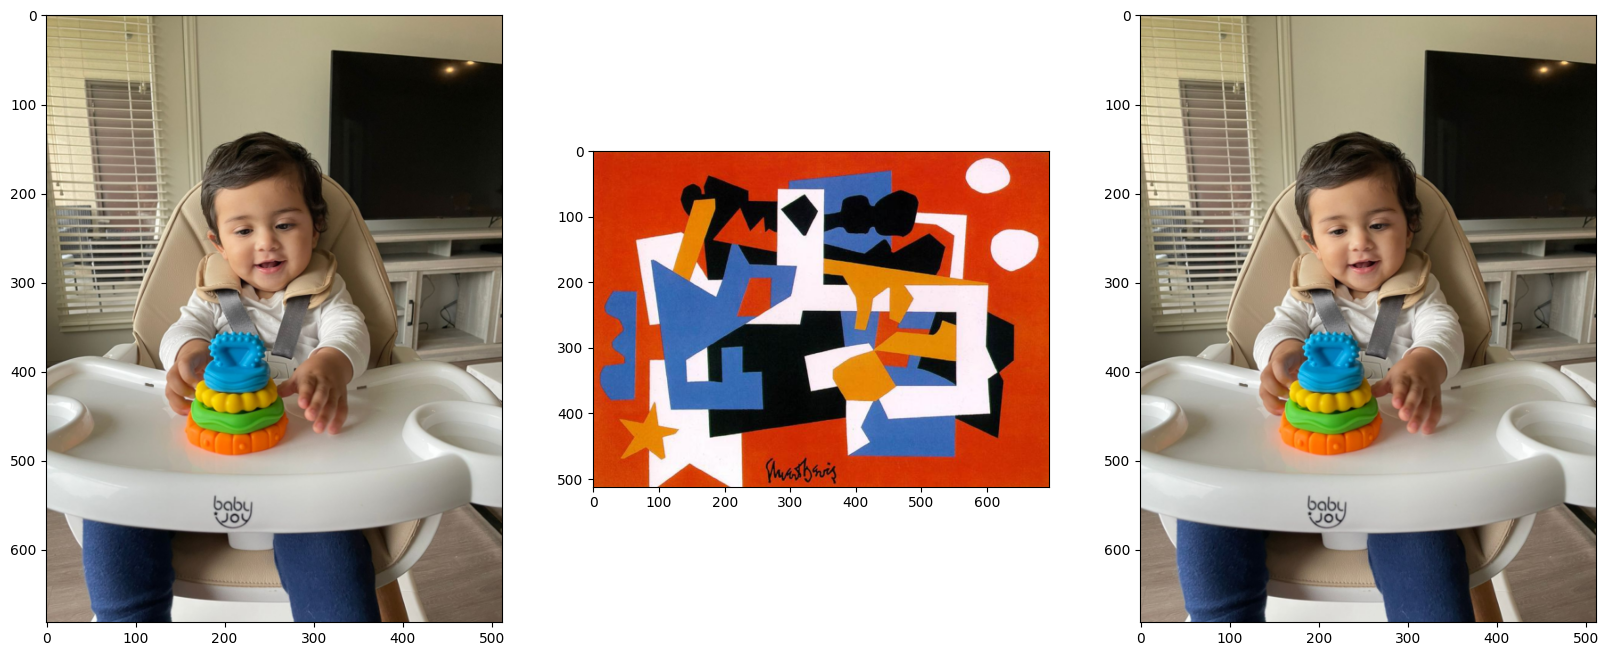

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(pastiche))

In [ ]:
acnn = CNN(style, content, pastiche, alpha, beta)

output = acnn.trainAdam(150)
output.data.clamp_(0,1)
plt.imshow(im_convert(output))
plt.show()

In [ ]:
showImages(content,style,pastiche)

Epoch: 0
Pérdida Total:  tensor(10.0769, grad_fn=<AddBackward0>)


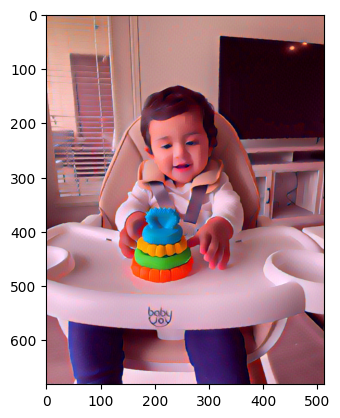

Epoch: 5
Pérdida Total:  tensor(2.1655, grad_fn=<AddBackward0>)


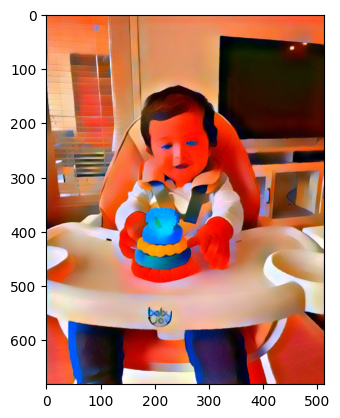

Epoch: 10
Pérdida Total:  tensor(1.3007, grad_fn=<AddBackward0>)


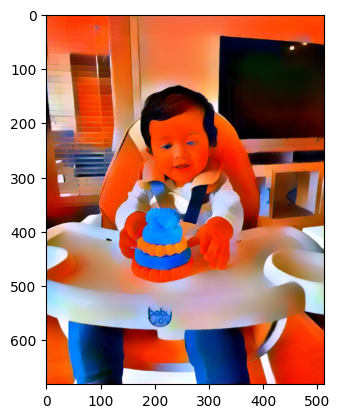

Epoch: 15
Pérdida Total:  tensor(1.8977, grad_fn=<AddBackward0>)


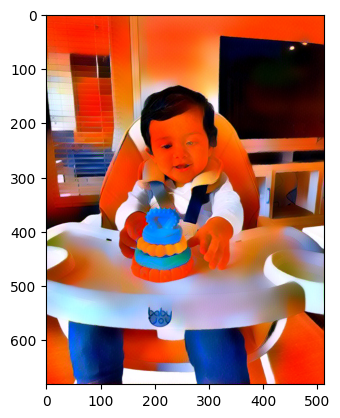

Epoch: 20
Pérdida Total:  tensor(1.3986, grad_fn=<AddBackward0>)


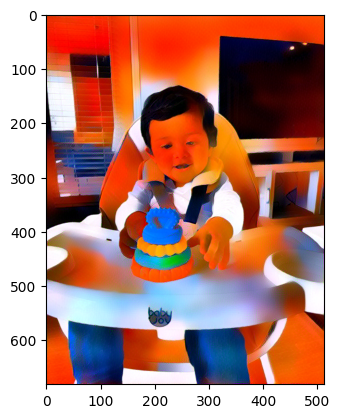

Epoch: 25
Pérdida Total:  tensor(1.3485, grad_fn=<AddBackward0>)


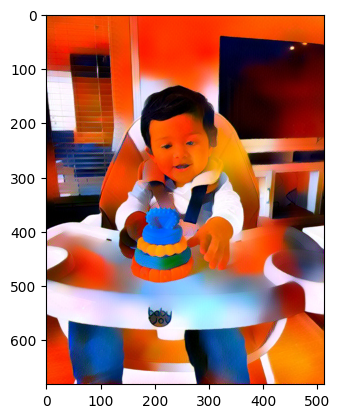

FileNotFoundError: [Errno 2] No such file or directory: '../data/out/output/25.png'

In [10]:
canva = content.clone()
cnn = CNN(style, content, canva, alpha, beta)
for i in range(epochs):
    canva = cnn.trainLBFGS()

    if i % 5 == 0:
        print("Epoch: %d" % (i))

        path = '../data/out/output/%d.png' % (i)
        canva.data.clamp_(0 ,1) #normalizes tensor (any value less than 0 will be 0 and more than 1 will be 1)
        print("Pérdida Total: ", cnn.total_loss)
        plt.imshow(im_convert(canva))
        plt.show()
        
save_image(canva, path)

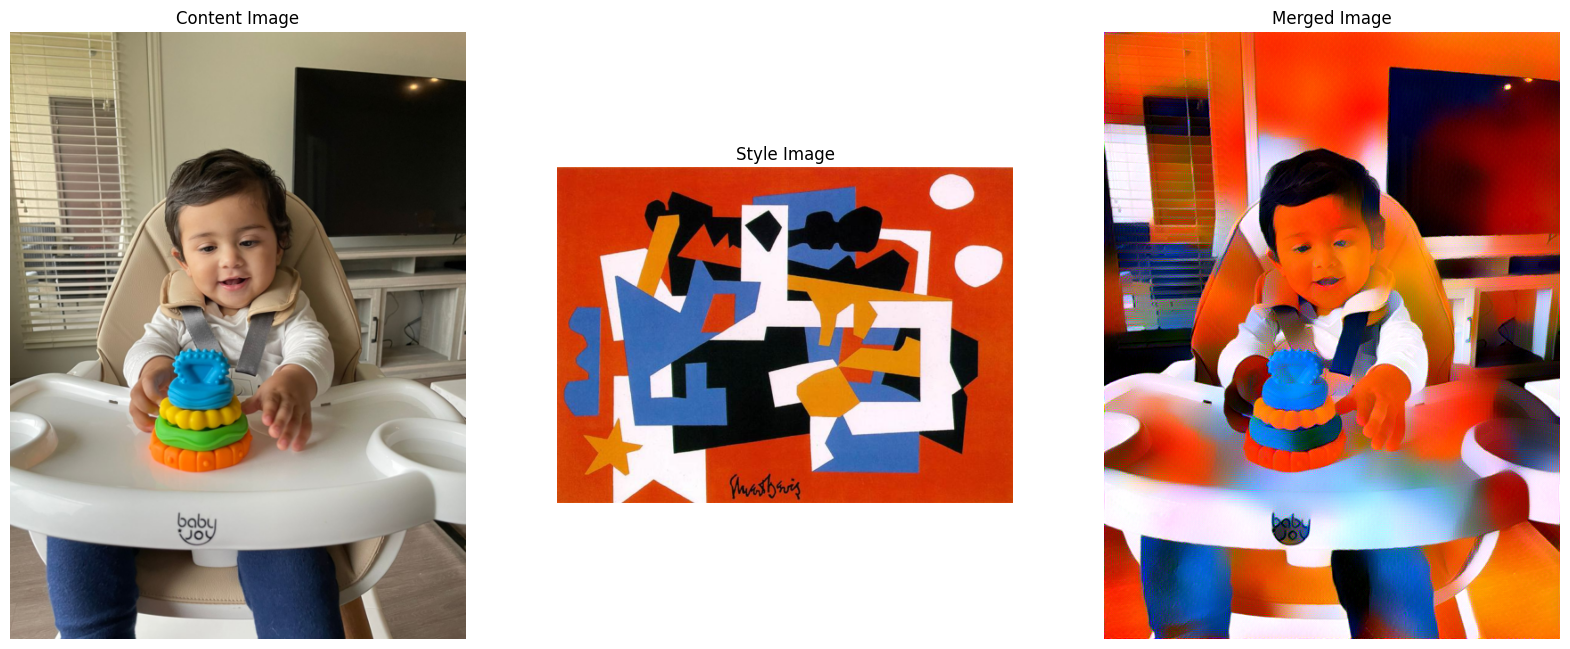

In [11]:
showImages(content,style,canva)